In [78]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
! pip install kaggle
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/find-a-car-park/data/Full/img_129092057.jpg
/kaggle/input/find-a-car-park/data/Full/img_1003232601.jpg
/kaggle/input/find-a-car-park/data/Full/img_129090558.jpg
/kaggle/input/find-a-car-park/data/Full/img_923073057.jpg
/kaggle/input/find-a-car-park/data/Full/img_919145058.jpg
/kaggle/input/find-a-car-park/data/Full/img_729073007.jpg
/kaggle/input/find-a-car-park/data/Full/img_907060058.jpg
/kaggle/input/find-a-car-park/data/Full/img_1011175057.jpg
/kaggle/input/find-a-car-park/data/Full/img_902085058.jpg
/kaggle/input/find-a-car-park/data/Full/img_822151558.jpg
/kaggle/input/find-a-car-park/data/Full/img_915014102.jpg
/kaggle/input/find-a-car-park/data/Full/img_909134558.jpg
/kaggle/input/find-a-car-park/data/Full/img_1005055102.jpg
/kaggle/input/find-a-car-park/data/Full/img_723023006.jpg
/kaggle/input/find-a-car-park/data/Full/img_925055558.jpg
/kaggle/input/find-a-car-park/data/Full/img_921214103.jpg
/kaggle/input/find-a-car-park/data/Full/img_925000102.jpg
/kaggle/inp

In [79]:
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline
!rm -rf runs yolov5

!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt  # install dependencies
!cp yolov5/requirements.txt ./


!pip install ultralytics

#We get a pretrained model

Cloning into 'yolov5'...
remote: Enumerating objects: 16057, done.
remote: Total 16057 (delta 0), reused 0 (delta 0), pack-reused 16057
Receiving objects: 100% (16057/16057), 14.68 MiB | 26.00 MiB/s, done.
Resolving deltas: 100% (11032/11032), done.


In [80]:
import ultralytics
ultralytics.checks()
from ultralytics import YOLO


Ultralytics YOLOv8.0.208 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5122.3/8062.4 GB disk)


model = YOLO('yolov8s.pt')  # load a pretrained model
model
BASE_PATH = "/kaggle/input/car-object-detection/data"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "training_images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "train_solution_bounding_boxes (1).csv"])
BASE_OUTPUT = "output"
os.makedirs(BASE_OUTPUT, exist_ok=True)
# define the path to the output serialized model, model training plot,
# and testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])
rows = open(ANNOTS_PATH).read().strip().split("\n")
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
filenames = []

In [81]:
h, w, channels = (380, 676, 3)
df = pd.read_csv('/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv')
print(df)
df['image'] = df['image'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['width_of_box'] = df['xmax'] - df['xmin']
df['height_of_box'] = df['ymax'] - df['ymin']
df['classes'] = 0
#Here we are normalizing our data
df['x_center'] = df['x_center']/w
df['width_of_box'] = df['width_of_box']/w
df['y_center'] = df['y_center']/h
df['height_of_box'] = df['height_of_box']/h
#df.head()

               image        xmin        ymin        xmax        ymax
0     vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1    vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2    vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3    vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4    vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422
..               ...         ...         ...         ...         ...
554   vid_4_9860.jpg    0.000000  198.321729   49.235251  236.223284
555   vid_4_9880.jpg  329.876184  156.482351  536.664239  250.497895
556   vid_4_9900.jpg    0.000000  168.295823  141.797524  239.176652
557   vid_4_9960.jpg  487.428988  172.233646  616.917699  228.839864
558   vid_4_9980.jpg  221.558631  182.570434  348.585579  238.192196

[559 rows x 5 columns]


In [82]:
testing_set = []
for filename in os.listdir("/kaggle/input/car-object-detection/data/testing_images"):
    testing_set.append(filename)


['vid_5_26420.jpg', 'vid_5_31520.jpg', 'vid_5_29420.jpg', 'vid_5_31720.jpg', 'vid_5_26560.jpg', 'vid_5_27840.jpg', 'vid_5_28560.jpg', 'vid_5_28360.jpg', 'vid_5_25240.jpg', 'vid_5_29560.jpg', 'vid_5_29020.jpg', 'vid_5_30720.jpg', 'vid_5_26940.jpg', 'vid_5_31620.jpg', 'vid_5_31100.jpg', 'vid_5_31040.jpg', 'vid_5_31260.jpg', 'vid_5_29980.jpg', 'vid_5_26900.jpg', 'vid_5_29900.jpg', 'vid_5_30680.jpg', 'vid_5_26800.jpg', 'vid_5_30700.jpg', 'vid_5_26780.jpg', 'vid_5_28500.jpg', 'vid_5_27760.jpg', 'vid_5_27680.jpg', 'vid_5_26980.jpg', 'vid_5_27360.jpg', 'vid_5_31080.jpg', 'vid_5_30860.jpg', 'vid_5_26920.jpg', 'vid_5_30740.jpg', 'vid_5_26700.jpg', 'vid_5_26840.jpg', 'vid_5_27720.jpg', 'vid_5_31380.jpg', 'vid_5_26860.jpg', 'vid_5_26720.jpg', 'vid_5_29480.jpg', 'vid_5_28540.jpg', 'vid_5_26760.jpg', 'vid_5_25120.jpg', 'vid_5_28080.jpg', 'vid_5_30640.jpg', 'vid_5_26600.jpg', 'vid_5_31160.jpg', 'vid_5_25220.jpg', 'vid_5_27540.jpg', 'vid_5_29740.jpg', 'vid_5_27920.jpg', 'vid_5_26620.jpg', 'vid_5_3102

Image ID: vid_4_10480


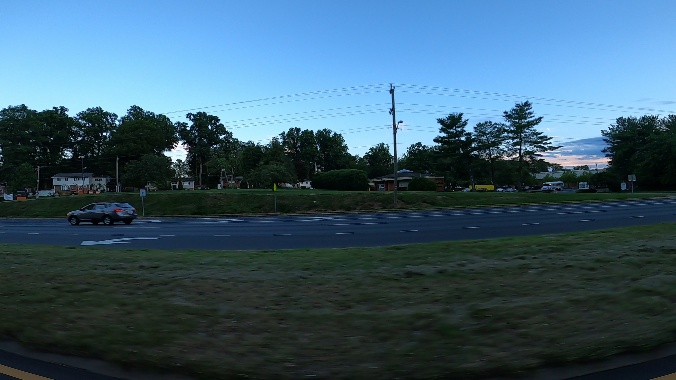

In [113]:
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'/kaggle/input/car-object-detection/data/training_images/{image}.jpg')
image = random.choice(index)
Image(filename=f'/kaggle/input/car-object-detection/data/training_images/{image}.jpg',width=600)

In [84]:
df = df.sample(frac=1, random_state=69)

# Set the desired proportion for the split (e.g., 70-30)
split_proportion = 0.9

# Calculate the number of rows for the first split
split_index = int(len(df) * split_proportion)

df_split1 = df.iloc[:split_index]
df_split2 = df.iloc[split_index:]


In [85]:
!python yolov5/train.py --batch 3 --epochs 1 --data ../input/yolov5-config/car.yaml --cfg ../input/yolov5-config/yolov5x.yaml --name yolov5x_fold0_new
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /kaggle/input/car-object-detection/data/testing_images

train: weights=yolov5/yolov5s.pt, cfg=../input/yolov5-config/yolov5x.yaml, data=../input/yolov5-config/car.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=1, batch_size=2, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=yolov5x_fold0_new, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: Ultralytics requirement ['Pillow>=10.0.1'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 11.2s, installed 1 package: ['Pillow>=10.0.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

Traceba

In [86]:
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("/kaggle/working/yolov5/runs/detect/exp"):
    predicted_files.extend(filenames)
#predicted_files

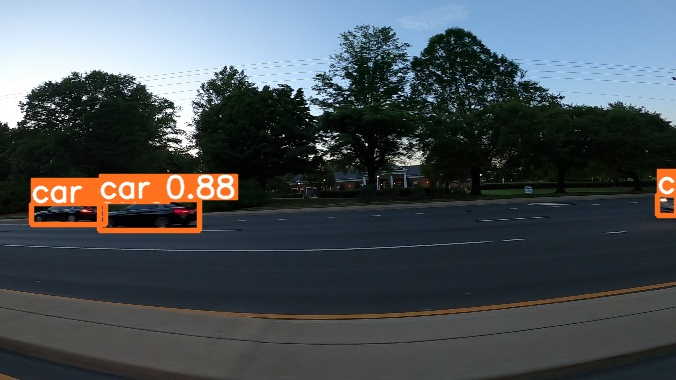

In [115]:
image = random.choice(testing_set)
Image(filename=f'/kaggle/working/yolov5/runs/detect/exp/{image}')
#random.choice(testing_set)

In [101]:
base_directory = '/kaggle/input/find-a-car-park/data'
Final_set = []
source = os.walk('/kaggle/input/find-a-car-park/data')

for root, dirs, files in os.walk(base_directory):
    for file in files:
        file_path = file
        # Save the file path relative to the base directory
        Final_set.append(file_path)
print(Final_set)


    

['img_129092057.jpg', 'img_1003232601.jpg', 'img_129090558.jpg', 'img_923073057.jpg', 'img_919145058.jpg', 'img_729073007.jpg', 'img_907060058.jpg', 'img_1011175057.jpg', 'img_902085058.jpg', 'img_822151558.jpg', 'img_915014102.jpg', 'img_909134558.jpg', 'img_1005055102.jpg', 'img_723023006.jpg', 'img_925055558.jpg', 'img_921214103.jpg', 'img_925000102.jpg', 'img_1008172058.jpg', 'img_925232102.jpg', 'img_1008113058.jpg', 'img_907145058.jpg', 'img_902112058.jpg', 'img_1005024602.jpg', 'img_723163007.jpg', 'img_919073058.jpg', 'img_909222103.jpg', 'img_920052101.jpg', 'img_907153558.jpg', 'img_919063058.jpg', 'img_906160558.jpg', 'img_1002092058.jpg', 'img_810062102.jpg', 'img_920190102.jpg', 'img_910184601.jpg', 'img_904072558.jpg', 'img_1004064558.jpg', 'img_1013121057.jpg', 'img_1002011102.jpg', 'img_922232102.jpg', 'img_902164558.jpg', 'img_925230602.jpg', 'img_915072058.jpg', 'img_129084057.jpg', 'img_902072058.jpg', 'img_911010102.jpg', 'img_914034103.jpg', 'img_925002102.jpg', 'i

In [110]:
#Trains the final set
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /kaggle/input/find-a-car-park/data/Free
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /kaggle/input/find-a-car-park/data/Full

detect: weights=['yolov5/yolov5s.pt'], source=/kaggle/input/find-a-car-park/data/Free, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: Ultralytics requirement ['Pillow>=10.0.1'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 11.5s, installed 1 package: ['Pillow>=10.0.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
WARNING ⚠️ --img-size [676, 676] must be multiple of max stride 32, updat

In [108]:
Image(filename=f'/kaggle/working/yolov5/runs/detect/exp/{random.choice(testing_set)}')
Image(filename=f'/kaggle/working/yolov5/runs/detect/exp/{random.choice(Final_set)}')


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/yolov5/runs/detect/exp/img_1009180558.jpg'